In [36]:
##############################################################
## CLTV PREDICTIONS with  BG-NBD and Gamma-Gamma MODELS on Online Retails Dataset
##############################################################

#####################################################
# DATASET
#####################################################
#This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered #non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.
## https://archive.ics.uci.edu/ml/datasets/Online+Retail+II

#Attribute Information
#Additional Information

#InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it #indicates a cancellation.
#StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
#Description: Product (item) name. Nominal.
#Quantity: The quantities of each product (item) per transaction. Numeric.
#InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.
#UnitPrice: Unit price. Numeric, Product price per unit in sterling.
#CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
#Country: Country name. Nominal, the name of the country where each customer resides.

In [37]:
###############################################################
#DATA PREPROCESSING
###############################################################
#Importing Libraries

! pip install lifetimes
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
from sklearn.preprocessing import MinMaxScaler

In [38]:
###############################################################
#  OUTLIER DETECTION AND REPLACING WITH THRESHOLDS FUNCTIONS
###############################################################
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    # dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [39]:
#########################
# READ THE DATA
#########################

df_ = pd.read_excel("online_retail_II.xlsx",
                    sheet_name="Year 2010-2011")
df = df_.copy()
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541910.0000,9.5522,218.0810,-80995.0000,1.0000,3.0000,10.0000,80995.0000
Price,541910.0000,4.6111,96.7598,-11062.0600,1.2500,2.0800,4.1300,38970.0000
Customer ID,406830.0000,15287.6842,1713.6031,12346.0000,13953.0000,15152.0000,16791.0000,18287.0000


In [40]:
df.head()


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.5500,17850.0000,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.7500,17850.0000,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom


In [41]:
#Let's drop NULL values, our dataset is rich enough
df.dropna(inplace=True)

In [42]:
#There was a known issue in the story of this dataset. In the Invoice part, there were statements with C at the beginning.
# These are returned purchases. And causing – (negative) values. These observations negatively affects the variables of quantity and price.
# Let's delete these negative values first.
df = df[~df["Invoice"].str.contains("C", na=False)]

In [43]:
# After A describe query, here we see negative values in quantity and price variable. We need to fix this problem as well
df = df[(df['Quantity'] > 0)]

In [44]:
# Lets fix price variable
df = df[(df["Price"] >0)]

In [45]:
# Now, we can run our functions to replace outliers with thresholds
replace_with_thresholds(df, "Quantity")
replace_with_thresholds(df, "Price")

# We need to create new variable called "TotalPrice" to calculate CLTV score
df["TotalPrice"] = df["Quantity"] * df["Price"]

In [46]:
# IN order to analyze, firstly an analysis date should be set which is 2 days later than the latest order date in dataset
df["InvoiceDate"].max()

Timestamp('2011-12-09 12:50:00')

In [47]:
today_date = dt.datetime(2011, 12, 11)

In [48]:
# steps of creating a new dataframe to work on it called as cltv_df :"recency', 'T', 'frequency', 'monetary"

cltv_df = df.groupby('Customer ID').agg(
    {'InvoiceDate': [lambda InvoiceDate: (InvoiceDate.max() - InvoiceDate.min()).days,
                     lambda InvoiceDate: (today_date - InvoiceDate.min()).days],
     'Invoice': lambda Invoice: Invoice.nunique(),
     'TotalPrice': lambda TotalPrice: TotalPrice.sum()})

cltv_df.columns = cltv_df.columns.droplevel(0)

cltv_df.columns = ['recency', 'T', 'frequency', 'monetary']

cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"]

cltv_df.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,4338.0000,130.4486,132.0396,0.0000,0.0000,92.5000,251.7500,373.0000
T,4338.0000,223.8310,117.8546,1.0000,113.0000,249.0000,327.0000,374.0000
frequency,4338.0000,4.2720,7.6980,1.0000,1.0000,2.0000,5.0000,209.0000
monetary,4338.0000,364.1185,367.2582,3.4500,176.8512,288.2255,422.0294,6207.6700


In [49]:
# Frequency should be at least 2 to filter repeated customers
cltv_df = cltv_df[(cltv_df['frequency'] > 1)]

In [50]:
#receny and T values should be in weeks
cltv_df["recency"] = cltv_df["recency"] / 7

cltv_df["T"] = cltv_df["T"] / 7

In [51]:
##############################################################
# 2. BG-NBD Model
##############################################################

In [52]:

bgf = BetaGeoFitter(penalizer_coef=0.001)

bgf.fit(cltv_df['frequency'],
        cltv_df['recency'],
        cltv_df['T'])

<lifetimes.BetaGeoFitter: fitted with 2845 subjects, a: 0.12, alpha: 11.41, b: 2.49, r: 2.18>

In [56]:
################################################################
# Let's predict top 10 customers expected in next 1 week period
################################################################

bgf.conditional_expected_number_of_purchases_up_to_time(1,
                                                        cltv_df['frequency'],
                                                        cltv_df['recency'],
                                                        cltv_df['T']).sort_values(ascending=False).head(10)
# Same function
bgf.predict(1,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sort_values(ascending=False).head(10)


Customer ID
12748.0000   3.2495
14911.0000   3.1264
17841.0000   1.9402
13089.0000   1.5374
14606.0000   1.4639
15311.0000   1.4336
12971.0000   1.3569
14646.0000   1.2064
13408.0000   0.9862
18102.0000   0.9685
dtype: float64

In [57]:
# let'precdict CLTV Scores for all customers
cltv_df["expected_purc_1_week"] = bgf.predict(1,
                                              cltv_df['frequency'],
                                              cltv_df['recency'],
                                              cltv_df['T'])
cltv_df.head()

,recency,T,frequency,monetary,expected_purc_1_week
Customer ID,,,,,
12347.0000,52.1429,52.5714,7,615.7143,0.1413
12348.0000,40.2857,51.2857,4,442.6950,0.0920
12352.0000,37.1429,42.4286,8,219.5425,0.1824
12356.0000,43.1429,46.5714,3,937.1433,0.0862
12358.0000,21.2857,21.5714,2,575.2100,0.1223


In [58]:
################################################################
# Let's predict top 5 customers expected in next 1 month period
################################################################
bgf.predict(4,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sort_values(ascending=False).head(5)


Customer ID
12748.0000   12.9633
14911.0000   12.4722
17841.0000    7.7398
13089.0000    6.1330
14606.0000    5.8399
dtype: float64

In [62]:
################################################################
# Let's predict all revenues for next 3 months
################################################################

bgf.predict(4 * 3,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sum()

5271.112433826359

In [63]:
#Here we save it to dataframe
cltv_df["expected_purc_3_month"] = bgf.predict(4 * 3,
                                               cltv_df['frequency'],
                                               cltv_df['recency'],
                                               cltv_df['T'])
cltv_df.head()

,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_3_month
Customer ID,,,,,,
12347.0000,52.1429,52.5714,7,615.7143,0.1413,1.6784
12348.0000,40.2857,51.2857,4,442.6950,0.0920,1.0920
12352.0000,37.1429,42.4286,8,219.5425,0.1824,2.1631
12356.0000,43.1429,46.5714,3,937.1433,0.0862,1.0222
12358.0000,21.2857,21.5714,2,575.2100,0.1223,1.4388


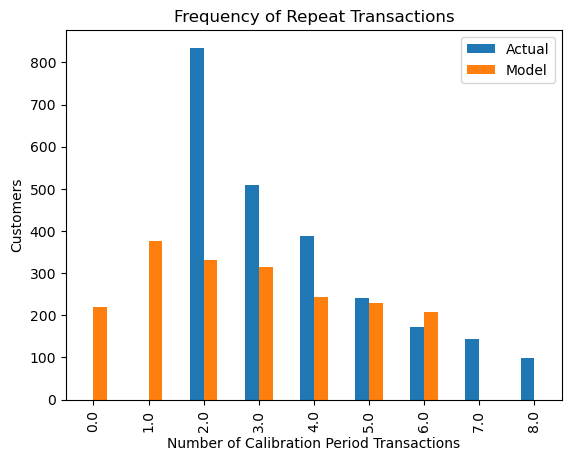

In [64]:
################################################################
# Evaluation of Prediction Results
################################################################

plot_period_transactions(bgf)
plt.show()

In [65]:
##############################################################
# 3. GAMMA-GAMMA Model
##############################################################

ggf = GammaGammaFitter(penalizer_coef=0.01)

ggf.fit(cltv_df['frequency'], cltv_df['monetary'])

ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                        cltv_df['monetary']).head(10)
#Let's see top ten customers with expected average profit
ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                        cltv_df['monetary']).sort_values(ascending=False).head(10)

Customer ID
12415.0000   5772.1782
12590.0000   5029.4196
12435.0000   4288.9440
12409.0000   3918.8128
14088.0000   3917.1297
18102.0000   3870.9969
12753.0000   3678.5783
14646.0000   3654.8148
15749.0000   3216.0523
14096.0000   3196.4361
dtype: float64

In [66]:
# Let's save it to dataframe
cltv_df["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                                                             cltv_df['monetary'])
cltv_df.sort_values("expected_average_profit", ascending=False).head(5)

,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_3_month,expected_average_profit
Customer ID,,,,,,,
12415.0000,44.7143,48.2857,21,5724.3026,0.3796,4.5080,5772.1782
12590.0000,0.0000,30.2857,2,4591.1725,0.0115,0.1363,5029.4196
12435.0000,26.8571,38.2857,2,3914.9450,0.0763,0.9035,4288.9440
12409.0000,14.7143,26.1429,3,3690.8900,0.1174,1.3854,3918.8128
14088.0000,44.5714,46.1429,13,3864.5546,0.2603,3.0896,3917.1297


In [67]:
##############################################################
# CALCULATION OF CLTV SCORES WITH BG-NBD and GAMMA GAMMA MODELS.
##############################################################

cltv = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency'],
                                   cltv_df['T'],
                                   cltv_df['monetary'],
                                   time=3,  # 3 months
                                   freq="W",  # freqeuency  value of "T" in weeks.
                                   discount_rate=0.01)

cltv.head()

Customer ID
12347.0000   1128.4477
12348.0000    538.8089
12352.0000    517.5000
12356.0000   1083.0903
12358.0000    966.6727
Name: clv, dtype: float64

In [68]:
cltv = cltv.reset_index()

cltv.head()

,Customer ID,clv
0,12347.0000,1128.4477
1,12348.0000,538.8089
2,12352.0000,517.5000
3,12356.0000,1083.0903
4,12358.0000,966.6727


In [69]:
# MERGE IT TO CLTV_DF
cltv_final = cltv_df.merge(cltv, on="Customer ID", how="left")
cltv_final.sort_values(by="clv", ascending=False).head(10)

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_3_month,expected_average_profit,clv
1122,14646.0000,50.4286,50.7143,73,3646.0757,1.2064,14.3340,3654.8148,55741.0845
2761,18102.0000,52.2857,52.5714,60,3859.7391,0.9685,11.5112,3870.9969,47412.5801
843,14096.0000,13.8571,14.5714,17,3163.5882,0.7287,8.5526,3196.4361,29061.6614
36,12415.0000,44.7143,48.2857,21,5724.3026,0.3796,4.5080,5772.1782,27685.1000
1257,14911.0000,53.1429,53.4286,201,691.7101,3.1264,37.1641,692.3264,27377.4115
2458,17450.0000,51.2857,52.5714,46,2863.2749,0.7474,8.8830,2874.1987,27166.0643
874,14156.0000,51.5714,53.1429,55,2104.0267,0.8775,10.4298,2110.7542,23424.4032
2487,17511.0000,52.8571,53.4286,31,2933.9431,0.5088,6.0476,2950.5801,18986.6123
2075,16684.0000,50.4286,51.2857,28,2209.9691,0.4781,5.6801,2223.8850,13440.4131
650,13694.0000,52.7143,53.4286,50,1275.7005,0.8008,9.5186,1280.2183,12966.1347


In [70]:
##############################################################
# 5. Identifying New CLTV Segments
##############################################################
# New 4 segments have been identified from the bottom "D" to top "A" segments
cltv_final

cltv_final["segment"] = pd.qcut(cltv_final["clv"], 4, labels=["D", "C", "B", "A"])

cltv_final.sort_values(by="clv", ascending=False).head()

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_3_month,expected_average_profit,clv,segment
1122,14646.0000,50.4286,50.7143,73,3646.0757,1.2064,14.3340,3654.8148,55741.0845,A
2761,18102.0000,52.2857,52.5714,60,3859.7391,0.9685,11.5112,3870.9969,47412.5801,A
843,14096.0000,13.8571,14.5714,17,3163.5882,0.7287,8.5526,3196.4361,29061.6614,A
36,12415.0000,44.7143,48.2857,21,5724.3026,0.3796,4.5080,5772.1782,27685.1000,A
1257,14911.0000,53.1429,53.4286,201,691.7101,3.1264,37.1641,692.3264,27377.4115,A


In [71]:
#Here we take descriptive statistics for the segments
cltv_c.groupby("segment").agg({"count", "mean", "sum"})
cltv_final.groupby("segment").agg(
    {"count", "mean", "sum"})


Customer ID                     recency                        T               frequency                  monetary                expected_purc_1_week              expected_purc_3_month              expected_average_profit                         clv                
                  sum       mean count        sum    mean count        sum    mean count       sum    mean count         sum     mean count                  sum   mean count                   sum   mean count                     sum     mean count          sum      mean count
segment                                                                                                                                                                                                                                                                             
D       11077635.0000 15558.4761   712 15716.5714 22.0738   712 28811.0000 40.4649   712      2182  3.0646   712 130981.7123 183.9631   712              50.5898 0.0711   712              598.0905 0.8400   712             141999.6650 199.4377   712  102027.4901  143.2970   712
C       10885150.0000 15309.6343   711 21806.1429 30.6697   711 27097.0000 38.1111   711      2912  4.0956   711 193174.9847 271.6948   711              85.7309 0.1206   711             1013.2176 1.4251   711             206179.7461 289.9856   711  270743.0065  380.7919   711
B       10915854.0000 15352.8186   711 20985.0000 29.5148   711 24751.1429 34.8117   711      3869  5.4416   711 265517.6312 373.4425   711             115.5066 0.1625   711             1362.6595 1.9165   711             280058.9431 393.8944   711  489356.3925  688.2650   711
A       10627572.0000 14947.3586   711 22333.1429 31.4109   711 24518.1429 34.4840   711      8076 11.3586   711 469159.4581 659.8586   711             194.4993 0.2736   711             2297.1448 3.2309   711             487674.7239 685.8998   711 1580097.9284 2222.3600   711